Misc imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import matplotlib.pyplot as plt
from six.moves.cPickle import load
import cPickle
import numpy as np

from snorkel import SnorkelSession
from snorkel.parser import XMLMultiDocPreprocessor, CorpusParser
from snorkel.parser.spacy_parser import Spacy
from snorkel.parser.corenlp import StanfordCoreNLPServer
from snorkel.models import Document, Sentence, Candidate, candidate_subclass
from snorkel.candidates import Ngrams, CandidateExtractor
from snorkel.viewer import SentenceNgramViewer
from snorkel.annotations import LabelAnnotator, load_gold_labels, FeatureAnnotator, save_marginals, load_marginals
from snorkel.learning import SparseLogisticRegression, GenerativeModel, RandomSearch
from snorkel.learning.structure import DependencySelector
from snorkel.learning.utils import MentionScorer
# from snorkel.contrib.rnn import reRNN

import matchers
import LF
from candidate_adjective_fixer import *
from load_external_annotations_new import load_external_labels

session = SnorkelSession()

BiomarkerType = candidate_subclass('BiomarkerType', ['biomarker', 'tipo'])



/Users/gmachiraju/py2_kernel/lib/python2.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 162 of the file /usr/local/Cellar/python/2.7.9/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


Helper functions

In [2]:
#------------------
# Helper Functions
#------------------

def grabCandidates(extractor, schema):
    # Candidate Counts
    for k, sents in enumerate([train_sents, dev_sents, test_sents]):
        extractor.apply(sents, split=k, clear=False)
        print "Number of candidates: ", session.query(schema).filter(schema.split == k).count()
        session.commit()
        
    train_cands = session.query(schema).filter(
        schema.split == 0).all()
    dev_cands = session.query(schema).filter(
        schema.split == 1).all()
    test_cands = session.query(schema).filter(
        schema.split == 2).all()

    return [train_cands, dev_cands, test_cands]

In [3]:
#-----------------------
# Setup & Preprocessing
#-----------------------

# Instantiate the Session
session = SnorkelSession()

# Doc Preprocessing
file_path = 'articles/training.xml'
train_preprocessor = XMLMultiDocPreprocessor(
    path=file_path,
    doc='.//article',
    text='.//front/article-meta/abstract/p/text()',
    id='.//front/article-meta/article-id/text()'
)

file_path = 'articles/development.xml'
dev_preprocessor = XMLMultiDocPreprocessor(
    path=file_path,
    doc='.//document',
    text='.//passage/text/text()',
    id='.//id/text()'
)

file_path = 'articles/testcorpus.xml'
test_preprocessor = XMLMultiDocPreprocessor(
    path=file_path,
    doc='.//document',
    text='.//passage/text/text()',
    id='.//id/text()'
)

# Parsing
# corenlp_server = StanfordCoreNLPServer(version="3.6.0", num_threads=4, port=12348)
# corpus_parser = CorpusParser(corenlp_server, parser=Spacy())
corpus_parser = CorpusParser(parser=Spacy())
# corpus_parser = CorpusParser()

# Note: Parallelism can be run with a Postgres DBMS, but not SQLite
corpus_parser.apply(list(train_preprocessor))
corpus_parser.apply(list(dev_preprocessor), clear=False)
corpus_parser.apply(list(test_preprocessor), clear=False)



Clearing existing...
Running UDF...
[========================================] 100%

Running UDF...
[========================================] 100%

Running UDF...
[========================================] 100%



In [4]:
# Retrieving Stable IDs for each of the candidate sentences
with open('articles/doc_ids.pkl', 'rb') as f:
    train_ids, dev_ids, test_ids = load(f)

train_ids, dev_ids, test_ids = set(train_ids), set(dev_ids), set(test_ids)
train_sents, dev_sents, test_sents = set(), set(), set()
docs = session.query(Document).order_by(Document.name).all()


# Assigning each sentence to {train,dev,test}-set based on Stable ID
for i, doc in enumerate(docs):
    for s in doc.sentences:
        if doc.name in train_ids:
            train_sents.add(s)
        elif doc.name in dev_ids:
            dev_sents.add(s)
        elif doc.name in test_ids:
            test_sents.add(s)
        else:
            raise Exception(
                'ID <{0}> not found in any id set'.format(doc.name))

In [5]:
#----------------------
# Candidate Extraction
#----------------------

# Defining the Candidate Schemas
# BiomarkerCondition = candidate_subclass('BiomarkerCondition', ['biomarker', 'condition'])

# BiomarkerDrug = candidate_subclass('BiomarkerDrug', ['biomarker', 'drug'])
# BiomarkerMedium = candidate_subclass('BiomarkerMedium', ['biomarker', 'medium'])
# BiomarkerType = candidate_subclass('BiomarkerType', ['biomarker', 'typ3'])
# # BiomarkerLevelUnit = candidate_subclass('BiomarkerLevelUnit', ['biomarker', 'level', 'unit'])
#can eventually add MEASUREMENT and COHORT SIZE among other entities

# N-grams: the probabilistic search space of our entities
biomarker_ngrams = Ngrams(n_max=1)
# condition_ngrams = Ngrams(n_max=7)
# drug_ngrams = Ngrams(n_max=5)
# medium_ngrams = Ngrams(n_max=5)
type_ngrams = Ngrams(n_max=5)  # <--- Q: should we cut these down?
# # level_ngrams = Ngrams(n_max=1)
# unit_ngrams = Ngrams(n_max=1)

# Construct our Matchers
bMatcher = matchers.getBiomarkerMatcher()
# cMatcher = matchers.getConditionMatcher()
# dMatcher = matchers.getDrugMatcher()
# mMatcher = matchers.getMediumMatcher()
tMatcher = matchers.getTypeMatcher()
# lMatcher = matchers.getLevelMatcher()
# uMatcher = matchers.getUnitMatcher()

# Building the CandidateExtractors
# candidate_extractor_BC = CandidateExtractor(BiomarkerCondition, [biomarker_ngrams, condition_ngrams], [bMatcher, cMatcher])
# candidate_extractor_BD = CandidateExtractor(BiomarkerDrug, [biomarker_ngrams, drug_ngrams], [bMatcher, dMatcher])
# candidate_extractor_BM = CandidateExtractor(BiomarkerMedium, [biomarker_ngrams, medium_ngrams], [bMatcher, mMatcher])
candidate_extractor_BT = CandidateExtractor(BiomarkerType, [biomarker_ngrams, type_ngrams], [bMatcher, tMatcher])
# candidate_extractor_BLU = CandidateExtractor(BiomarkerLevelUnit, [biomarker_ngrams, level_ngrams, unit_ngrams], [bMatcher, lMatcher, uMatcher])

# List of Candidate Sets for each relation type: [train, dev, test]
# cands_BC = grabCandidates(candidate_extractor_BC, BiomarkerCondition)
# cands_BD = grabCandidates(candidate_extractor_BD, BiomarkerDrug)
# cands_BM = grabCandidates(candidate_extractor_BM, BiomarkerMedium)
cands_BT = grabCandidates(candidate_extractor_BT, BiomarkerType)
# cands_BLU = grabCandidates(candidate_extractor_BLU, BiomarkerLevelUnit)



Running UDF...
[========================================] 100%

Number of candidates:  2377
Running UDF...
[========================================] 100%

Number of candidates:  431
Running UDF...
[========================================] 100%

Number of candidates:  45


In [6]:
from LF import *
LFs_BT = [LF_colon, LF_known_abs, LF_single_letter, LF_roman_numeral, LF_common_2000, LF_same_thing, LF_distance, LF_abstract_titleWord, 
          LF_auxpass, LF_markerDatabase, LF_is_in_typeDatabase]


In [7]:
from snorkel.annotations import LabelAnnotator
BT_labeler = LabelAnnotator(lfs=LFs_BT)

In [8]:
np.random.seed(1701)
%time L_train_BT = BT_labeler.apply(split=0)
L_train_BT

Clearing existing...
Running UDF...
[=                                       ] 0%Span("CAR", sentence=8559, chars=[38,40], words=[9,9])
Span("PRRSV", sentence=3143, chars=[27,31], words=[4,4])
Span("zeta", sentence=4630, chars=[193,196], words=[31,31])
Span("zeta", sentence=4630, chars=[193,196], words=[31,31])
Span("zeta", sentence=4630, chars=[19,22], words=[3,3])
Span("zeta", sentence=4630, chars=[19,22], words=[3,3])
Span("zeta", sentence=4627, chars=[24,27], words=[5,5])
Span("CXCR4", sentence=4629, chars=[68,72], words=[12,12])
Span("zeta", sentence=4629, chars=[13,16], words=[3,3])
Span("PRRSV", sentence=3135, chars=[53,57], words=[7,7])
Span("Drp1", sentence=3138, chars=[76,79], words=[11,11])
Span("PRRSV", sentence=3138, chars=[0,4], words=[0,0])
Span("Ser616", sentence=3138, chars=[84,89], words=[13,13])
Span("Drp1", sentence=3138, chars=[42,45], words=[6,6])
Span("HPV", sentence=5271, chars=[29,31], words=[5,5])
Span("zeta", sentence=4631, chars=[5,8], words=[1,1])
Span("CXC

Span("TAA", sentence=11973, chars=[110,112], words=[22,22])
Span("OVA", sentence=11973, chars=[126,128], words=[26,26])
Span("VEGF", sentence=1362, chars=[4,7], words=[1,1])
Span("VEGF", sentence=1362, chars=[153,156], words=[26,26])
Span("DCL", sentence=5079, chars=[91,93], words=[18,18])
[===                                     ] 6%Span("PLGA", sentence=5079, chars=[33,36], words=[5,5])
Span("PEG", sentence=5079, chars=[38,40], words=[7,7])
Span("DSB", sentence=2962, chars=[202,204], words=[37,37])
Span("LET", sentence=2962, chars=[107,109], words=[19,19])
Span("RBE", sentence=2962, chars=[116,118], words=[22,22])
Span("HER2", sentence=4416, chars=[0,3], words=[0,0])
Span("HER2", sentence=4416, chars=[0,3], words=[0,0])
Span("HER2", sentence=4416, chars=[0,3], words=[0,0])
Span("HER2", sentence=4416, chars=[0,3], words=[0,0])
Span("IHC", sentence=4416, chars=[107,109], words=[15,15])
Span("IHC", sentence=4416, chars=[107,109], words=[15,15])
Span("IHC", sentence=4416, chars=[107,109]

Span("VP1", sentence=3859, chars=[11,13], words=[2,2])
Span("CVB3", sentence=3859, chars=[71,74], words=[12,12])
Span("CVB3", sentence=3859, chars=[71,74], words=[12,12])
Span("MPM", sentence=8964, chars=[262,264], words=[49,49])
Span("MPM", sentence=8964, chars=[262,264], words=[49,49])
Span("MPM", sentence=8964, chars=[262,264], words=[49,49])
Span("NGS", sentence=8964, chars=[114,116], words=[23,23])
[=====                                   ] 12%Span("NGS", sentence=8964, chars=[114,116], words=[23,23])
Span("NGS", sentence=8964, chars=[114,116], words=[23,23])
Span("CATCH", sentence=8964, chars=[14,18], words=[5,5])
Span("CATCH", sentence=8964, chars=[14,18], words=[5,5])
Span("CATCH", sentence=8964, chars=[14,18], words=[5,5])
Span("mRNA", sentence=8964, chars=[155,158], words=[32,32])
Span("mRNA", sentence=8964, chars=[155,158], words=[32,32])
Span("TNBC", sentence=5745, chars=[82,85], words=[14,14])
Span("syndecan", sentence=5745, chars=[46,53], words=[6,6])
Span("SDCBP", senten

Span("DNMT", sentence=1435, chars=[135,138], words=[22,22])
Span("DNMT", sentence=1435, chars=[37,40], words=[5,5])
Span("CRISPR", sentence=11910, chars=[29,34], words=[5,5])
Span("R388P", sentence=9248, chars=[83,87], words=[13,13])
Span("R388P", sentence=9248, chars=[83,87], words=[13,13])
Span("R388P", sentence=9248, chars=[83,87], words=[13,13])
Span("C2C12", sentence=9248, chars=[0,4], words=[0,0])
Span("C2C12", sentence=9248, chars=[0,4], words=[0,0])
Span("C2C12", sentence=9248, chars=[0,4], words=[0,0])
Span("CRC", sentence=11702, chars=[108,110], words=[22,22])
Span("RNA", sentence=3216, chars=[0,2], words=[0,0])
[========                                ] 18%Span("R388P", sentence=9246, chars=[0,4], words=[0,0])
Span("CMD", sentence=9246, chars=[129,131], words=[22,22])
Span("MB11", sentence=5922, chars=[22,25], words=[5,5])
Span("MEQ", sentence=11764, chars=[248,250], words=[41,41])
Span("MAPK", sentence=11764, chars=[164,167], words=[26,26])
Span("MEQ", sentence=11764, chars

Span("SHANK3", sentence=5731, chars=[73,78], words=[15,15])
Span("SHANK3", sentence=5734, chars=[72,77], words=[14,14])
Span("BT", sentence=7575, chars=[25,26], words=[3,3])
Span("BT", sentence=7578, chars=[196,197], words=[35,35])
Span("H4", sentence=6160, chars=[147,148], words=[21,21])
Span("RIP1", sentence=6160, chars=[159,162], words=[27,27])
Span("ROS", sentence=6160, chars=[189,191], words=[32,32])
Span("SHANK3", sentence=5741, chars=[25,30], words=[5,5])
Span("CRISPR", sentence=12297, chars=[130,135], words=[25,25])
Span("TAIT", sentence=3008, chars=[60,63], words=[12,12])
Span("p53", sentence=3097, chars=[101,103], words=[17,17])
Span("PFIC2", sentence=3662, chars=[119,123], words=[18,18])
Span("PFIC2", sentence=3662, chars=[119,123], words=[18,18])
Span("BSEP", sentence=3662, chars=[32,35], words=[6,6])
Span("BSEP", sentence=3662, chars=[32,35], words=[6,6])
Span("BSEP", sentence=3662, chars=[45,48], words=[8,8])
[==========                              ] 24%Span("BSEP", sent

[============                            ] 29%Span("BAK", sentence=1881, chars=[154,156], words=[37,37])
Span("PARP", sentence=1881, chars=[91,94], words=[20,20])
Span("ECM", sentence=5682, chars=[145,147], words=[25,25])
Span("CAF", sentence=5682, chars=[139,141], words=[21,21])
Span("PDAC", sentence=5682, chars=[83,86], words=[13,13])
Span("eGFP", sentence=12104, chars=[110,113], words=[20,20])
Span("CDK", sentence=12104, chars=[4,6], words=[1,1])
Span("maspin", sentence=3052, chars=[115,120], words=[20,20])
Span("maspin", sentence=3052, chars=[115,120], words=[20,20])
Span("mRNA", sentence=3052, chars=[53,56], words=[9,9])
Span("maspin", sentence=3052, chars=[34,39], words=[6,6])
Span("maspin", sentence=3052, chars=[34,39], words=[6,6])
Span("ROCK", sentence=2653, chars=[72,75], words=[13,13])
Span("ECM", sentence=2653, chars=[185,187], words=[34,34])
Span("Rho", sentence=2653, chars=[18,20], words=[3,3])
Span("MeCP2", sentence=9710, chars=[68,72], words=[14,14])
Span("MeCP2", sente

Span("RNA", sentence=10802, chars=[215,217], words=[37,37])
Span("CXCL10", sentence=10802, chars=[98,103], words=[17,17])
Span("CXCL10", sentence=10802, chars=[98,103], words=[17,17])
Span("CXCL10", sentence=10802, chars=[20,25], words=[4,4])
Span("CXCL10", sentence=10802, chars=[20,25], words=[4,4])
Span("M2", sentence=8608, chars=[144,145], words=[19,19])
Span("IL-33", sentence=8608, chars=[164,168], words=[23,23])
[===============                         ] 35%Span("APP", sentence=6395, chars=[31,33], words=[5,5])
Span("D1R", sentence=5129, chars=[103,105], words=[16,16])
Span("SNP", sentence=11127, chars=[231,233], words=[38,38])
Span("SOD", sentence=2546, chars=[44,46], words=[7,7])
Span("MAP", sentence=5101, chars=[49,51], words=[9,9])
Span("PI3", sentence=5101, chars=[65,67], words=[13,13])
Span("VHH6", sentence=7462, chars=[36,39], words=[5,5])
Span("VHH6", sentence=7462, chars=[36,39], words=[5,5])
Span("RGC", sentence=5489, chars=[122,124], words=[22,22])
Span("E1", sentence=6

Span("NPC", sentence=6512, chars=[102,104], words=[19,19])
Span("mRNA", sentence=6512, chars=[26,29], words=[5,5])
Span("ALK5", sentence=9226, chars=[116,119], words=[19,19])
Span("SB431542", sentence=9226, chars=[19,26], words=[4,4])
Span("K562", sentence=11368, chars=[13,16], words=[2,2])
Span("K562", sentence=11368, chars=[13,16], words=[2,2])
Span("mRNA", sentence=11368, chars=[57,60], words=[10,10])
Span("GPA", sentence=11368, chars=[127,129], words=[21,21])
Span("GPA", sentence=11368, chars=[127,129], words=[21,21])
Span("gDNA", sentence=2025, chars=[124,127], words=[23,23])
Span("WGS", sentence=2025, chars=[9,11], words=[2,2])
Span("H9C2", sentence=7741, chars=[142,145], words=[24,24])
Span("BMSC", sentence=9227, chars=[58,61], words=[9,9])
[=================                       ] 41%Span("Runx2", sentence=9228, chars=[23,27], words=[4,4])
Span("Runx2", sentence=9228, chars=[23,27], words=[4,4])
Span("Runx2", sentence=9228, chars=[23,27], words=[4,4])
Span("Samd3", sentence=92

Span("DNA", sentence=5716, chars=[148,150], words=[21,21])
Span("DNMT", sentence=12244, chars=[178,181], words=[26,26])
Span("EGFP", sentence=12244, chars=[188,191], words=[29,29])
Span("CAG", sentence=12244, chars=[141,143], words=[20,20])
Span("SOX18", sentence=5718, chars=[140,144], words=[24,24])
Span("SOX18", sentence=5718, chars=[140,144], words=[24,24])
Span("FTD", sentence=6082, chars=[143,145], words=[25,25])
Span("FTD", sentence=6082, chars=[143,145], words=[25,25])
Span("HRE", sentence=6082, chars=[45,47], words=[6,6])
Span("HRE", sentence=6082, chars=[45,47], words=[6,6])
Span("ALS", sentence=6082, chars=[110,112], words=[20,20])
Span("ALS", sentence=6082, chars=[110,112], words=[20,20])
Span("PLCE1", sentence=7757, chars=[106,110], words=[17,17])
Span("PLCE1", sentence=7763, chars=[14,18], words=[3,3])
Span("SNAI2", sentence=1344, chars=[90,94], words=[15,15])
Span("FYN", sentence=1344, chars=[100,102], words=[17,17])
Span("PLCE1", sentence=7765, chars=[108,112], words=[16

Span("tau", sentence=5956, chars=[140,142], words=[21,21])
[=====================                   ] 52%Span("BCAS2", sentence=7994, chars=[36,40], words=[6,6])
Span("DAZL", sentence=8000, chars=[141,144], words=[29,29])
Span("BCAS2", sentence=8002, chars=[36,40], words=[6,6])
Span("CD4", sentence=11938, chars=[47,49], words=[9,9])
Span("WT1", sentence=4642, chars=[174,176], words=[28,28])
Span("WT1", sentence=4642, chars=[23,25], words=[4,4])
Span("KTS", sentence=4642, chars=[179,181], words=[30,30])
Span("GUTK", sentence=2972, chars=[15,18], words=[3,3])
Span("PFN1", sentence=2972, chars=[128,131], words=[19,19])
Span("HCC", sentence=2972, chars=[74,76], words=[11,11])
Span("TNBS", sentence=3593, chars=[0,3], words=[0,0])
Span("cAMP", sentence=3374, chars=[70,73], words=[10,10])
Span("FRET", sentence=3374, chars=[168,171], words=[27,27])
Span("GPCR", sentence=3374, chars=[96,99], words=[15,15])
Span("pOVA", sentence=7939, chars=[196,199], words=[35,35])
Span("T", sentence=11939, cha

Span("AITL", sentence=3405, chars=[161,164], words=[22,22])
Span("DNA", sentence=5927, chars=[93,95], words=[13,13])
Span("AAV2", sentence=9294, chars=[101,104], words=[18,18])
Span("AAV2", sentence=9294, chars=[26,29], words=[5,5])
Span("D371Y", sentence=9294, chars=[42,46], words=[9,9])
Span("qPCR", sentence=8316, chars=[100,103], words=[15,15])
Span("AAV2", sentence=9287, chars=[57,60], words=[11,11])
[========================                ] 58%Span("AAV2", sentence=9287, chars=[57,60], words=[11,11])
Span("HSV-1", sentence=9287, chars=[141,145], words=[26,26])
Span("HSV-1", sentence=9287, chars=[141,145], words=[26,26])
Span("HK-2", sentence=2246, chars=[196,199], words=[34,34])
Span("NLRP3", sentence=2246, chars=[125,129], words=[18,18])
Span("AMO", sentence=1885, chars=[32,34], words=[6,6])
Span("AAV2", sentence=9288, chars=[160,163], words=[28,28])
Span("HSV-1", sentence=9288, chars=[169,173], words=[30,30])
Span("D371Y", sentence=9292, chars=[39,43], words=[9,9])
Span("AAV2",

Span("RA1067", sentence=11164, chars=[105,110], words=[23,23])
Span("PCR", sentence=11164, chars=[41,43], words=[10,10])
Span("H2AX", sentence=12111, chars=[66,69], words=[10,10])
Span("ELISA", sentence=12111, chars=[20,24], words=[4,4])
Span("H2AX", sentence=12111, chars=[81,84], words=[13,13])
Span("TAIT", sentence=3016, chars=[15,18], words=[3,3])
Span("PCR", sentence=3016, chars=[58,60], words=[9,9])
Span("CRISPR", sentence=12529, chars=[91,96], words=[18,18])
Span("TLR2", sentence=1953, chars=[204,207], words=[33,33])
Span("ER", sentence=1953, chars=[46,47], words=[7,7])
Span("ER", sentence=1953, chars=[150,151], words=[25,25])
Span("NCI-60", sentence=12113, chars=[27,32], words=[4,4])
[==========================              ] 64%Span("PEDF", sentence=10932, chars=[94,97], words=[15,15])
Span("CREB", sentence=2446, chars=[218,221], words=[42,42])
Span("BDNF", sentence=2446, chars=[35,38], words=[6,6])
Span("ERK", sentence=2446, chars=[145,147], words=[27,27])
Span("AMP", sentence

Span("p53", sentence=3115, chars=[105,107], words=[16,16])
Span("p53", sentence=3115, chars=[105,107], words=[16,16])
Span("DNA", sentence=3115, chars=[165,167], words=[26,26])
Span("DNA", sentence=3115, chars=[165,167], words=[26,26])
Span("DNA", sentence=3115, chars=[165,167], words=[26,26])
Span("PCR", sentence=10235, chars=[27,29], words=[5,5])
Span("PHD2", sentence=3251, chars=[24,27], words=[4,4])
Span("nAMD", sentence=3253, chars=[96,99], words=[18,18])
Span("PHD2", sentence=3253, chars=[17,20], words=[3,3])
Span("HIF", sentence=3253, chars=[50,52], words=[9,9])
Span("TEG4", sentence=9321, chars=[46,49], words=[7,7])
Span("nAMD", sentence=3254, chars=[66,69], words=[10,10])
Span("IKK", sentence=1902, chars=[29,31], words=[5,5])
Span("R2R3-MYB", sentence=11044, chars=[12,19], words=[2,2])
Span("H19", sentence=1703, chars=[0,2], words=[0,0])
Span("VDR", sentence=1703, chars=[62,64], words=[14,14])
Span("CRISPR", sentence=2166, chars=[37,42], words=[7,7])
Span("dPCR", sentence=9277

[===============================         ] 75%Span("PCR", sentence=6374, chars=[85,87], words=[14,14])
Span("qPCR", sentence=6374, chars=[61,64], words=[9,9])
Span("qPCR", sentence=6374, chars=[61,64], words=[9,9])
Span("qPCR", sentence=6374, chars=[61,64], words=[9,9])
Span("DNA", sentence=6374, chars=[150,152], words=[24,24])
Span("NMD", sentence=5362, chars=[37,39], words=[7,7])
Span("PCNA", sentence=5502, chars=[89,92], words=[13,13])
Span("GWAM", sentence=5004, chars=[119,122], words=[23,23])
Span("GWAM", sentence=5004, chars=[119,122], words=[23,23])
Span("APOA1", sentence=5087, chars=[300,304], words=[57,57])
Span("CCI", sentence=5087, chars=[78,80], words=[12,12])
Span("TTR", sentence=5087, chars=[389,391], words=[78,78])
Span("APOE", sentence=5087, chars=[326,329], words=[63,63])
Span("H2", sentence=5087, chars=[347,348], words=[68,68])
Span("VDBP", sentence=5087, chars=[155,158], words=[27,27])
Span("PTGDS", sentence=5087, chars=[363,367], words=[73,73])
Span("M2", sentence=5

Span("NLG-1", sentence=8545, chars=[127,131], words=[26,26])
Span("NLG-1", sentence=8545, chars=[127,131], words=[26,26])
Span("ERK", sentence=8546, chars=[25,27], words=[6,6])
Span("LIN-45", sentence=8546, chars=[0,5], words=[0,0])
Span("GO", sentence=8546, chars=[139,140], words=[25,25])
[=================================       ] 81%Span("PKC-1", sentence=8546, chars=[100,104], words=[18,18])
Span("AMP", sentence=10258, chars=[11,13], words=[2,2])
Span("PKA", sentence=10258, chars=[33,35], words=[8,8])
Span("PKA", sentence=10258, chars=[142,144], words=[28,28])
Span("GO", sentence=8548, chars=[193,194], words=[27,27])
Span("NLG-1", sentence=8548, chars=[184,188], words=[25,25])
Span("FOXO", sentence=8548, chars=[65,68], words=[11,11])
Span("GO", sentence=8548, chars=[334,335], words=[48,48])
Span("NLG-1", sentence=8548, chars=[252,256], words=[36,36])
Span("MMP", sentence=11176, chars=[95,97], words=[12,12])
Span("iNOS", sentence=11176, chars=[103,106], words=[14,14])
Span("QTL", sen

Span("MAPK", sentence=4204, chars=[65,68], words=[9,9])
Span("BRAF", sentence=4204, chars=[146,149], words=[24,24])
Span("Cas9", sentence=4204, chars=[101,104], words=[16,16])
Span("ALK", sentence=4204, chars=[167,169], words=[31,31])
Span("MEK", sentence=4204, chars=[152,154], words=[26,26])
Span("NTS", sentence=12627, chars=[68,70], words=[12,12])
Span("NTS", sentence=12627, chars=[68,70], words=[12,12])
Span("RNA", sentence=12627, chars=[192,194], words=[35,35])
Span("NTS2", sentence=12627, chars=[101,104], words=[19,19])
Span("NTS2", sentence=12627, chars=[101,104], words=[19,19])
Span("RNA", sentence=12628, chars=[63,65], words=[11,11])
Span("p38", sentence=10477, chars=[39,41], words=[6,6])
[===================================     ] 87%Span("TCC", sentence=10477, chars=[233,235], words=[34,34])
Span("NEDD9", sentence=10477, chars=[29,33], words=[4,4])
Span("PA", sentence=9746, chars=[190,191], words=[45,45])
Span("PCR", sentence=9746, chars=[14,16], words=[4,4])
Span("PA", senten

Span("tau", sentence=5387, chars=[5,7], words=[1,1])
Span("DNA", sentence=11840, chars=[34,36], words=[3,3])
Span("Lin28", sentence=8048, chars=[226,230], words=[38,38])
Span("PpCSP1", sentence=8048, chars=[58,63], words=[14,14])
Span("dPCR", sentence=9284, chars=[15,18], words=[3,3])
Span("dPCR", sentence=9284, chars=[15,18], words=[3,3])
Span("dPCR", sentence=9284, chars=[15,18], words=[3,3])
Span("PpCSP1", sentence=8051, chars=[75,80], words=[12,12])
Span("FISH", sentence=3387, chars=[203,206], words=[33,33])
Span("PSME1", sentence=1468, chars=[84,88], words=[12,12])
Span("CSP1", sentence=8055, chars=[36,39], words=[7,7])
Span("Lin28", sentence=8055, chars=[129,133], words=[21,21])
Span("MSI", sentence=11872, chars=[17,19], words=[4,4])
Span("AAR", sentence=11872, chars=[8,10], words=[1,1])
Span("HCCL", sentence=7201, chars=[51,54], words=[12,12])
Span("DNA", sentence=10107, chars=[268,270], words=[40,40])
Span("DNA", sentence=10107, chars=[268,270], words=[40,40])
Span("DNA", sente

Span("BRRF2", sentence=6322, chars=[51,55], words=[10,10])
[========================================] 98%Span("STING", sentence=1978, chars=[106,110], words=[18,18])
Span("STING", sentence=1978, chars=[0,4], words=[0,0])
Span("TNM", sentence=1978, chars=[219,221], words=[36,36])
Span("LRBA", sentence=6651, chars=[75,78], words=[14,14])
Span("AIS", sentence=1903, chars=[242,244], words=[44,44])
Span("EGFP", sentence=9044, chars=[52,55], words=[10,10])
Span("LRBA", sentence=6657, chars=[25,28], words=[4,4])
Span("rAAV", sentence=2145, chars=[36,39], words=[6,6])
Span("CNS", sentence=2145, chars=[116,118], words=[22,22])
Span("ZIKV", sentence=12691, chars=[12,15], words=[3,3])
Span("MBP", sentence=4934, chars=[289,291], words=[43,43])
Span("T", sentence=11958, chars=[61,61], words=[8,8])
Span("L1", sentence=11958, chars=[162,163], words=[28,28])
Span("CTLA-4", sentence=11958, chars=[96,101], words=[16,16])
Span("MET", sentence=11880, chars=[145,147], words=[20,20])
Span("PVN", sentence=40

<2377x11 sparse matrix of type '<type 'numpy.int64'>'
	with 5897 stored elements in Compressed Sparse Row format>

In [9]:
%time L_train_BT = BT_labeler.load_matrix(session, split=0)
L_train_BT

CPU times: user 48.2 ms, sys: 1.07 ms, total: 49.3 ms
Wall time: 48.5 ms


<2377x11 sparse matrix of type '<type 'numpy.int64'>'
	with 5897 stored elements in Compressed Sparse Row format>

In [10]:
L_train_BT.get_candidate(session, 0)

BiomarkerType(Span("CAR", sentence=8559, chars=[38,40], words=[9,9]), Span("protein", sentence=8559, chars=[15,21], words=[4,4]))

In [11]:
L_train_BT.get_key(session, 0)

LabelKey (LF_colon)

In [12]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel()
gen_model.train(L_train_BT, epochs=100, decay=0.95, step_size=0.1 / L_train_BT.shape[0], reg_param=1e-6)

Inferred cardinality: 2


In [13]:
gen_model.weights.lf_accuracy

array([ 0.07056367,  0.10044848,  0.0715845 ,  0.07588406,  0.07719729,
        0.08412237,  1.20861171,  0.07659402, -0.03240209,  0.10141409,
        0.07286149])

In [14]:
train_marginals = gen_model.marginals(L_train_BT)


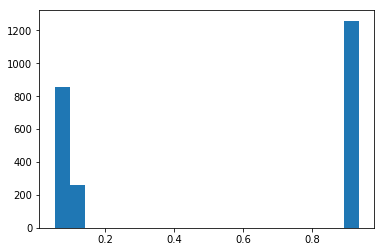

In [15]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

In [16]:
L_dev = BT_labeler.apply_existing(split=1)

Clearing existing...
Running UDF...
[=                                       ] 0%Span("CCAT2", sentence=13421, chars=[19,23], words=[3,3])
Span("CCAT2", sentence=13422, chars=[50,54], words=[8,8])
Span("BACKGROUND", sentence=13422, chars=[0,9], words=[0,0])
Span("EPO", sentence=14097, chars=[243,245], words=[44,44])
[=                                       ] 1%Span("CRP", sentence=14097, chars=[288,290], words=[56,56])
Span("SF", sentence=14097, chars=[193,194], words=[33,33])
Span("METHODS", sentence=14097, chars=[0,6], words=[0,0])
Span("HPV", sentence=13592, chars=[0,2], words=[0,0])
Span("mRNA", sentence=13594, chars=[22,25], words=[4,4])
[=                                       ] 2%Span("CONCLUSION", sentence=13594, chars=[0,9], words=[0,0])
Span("CONCLUSION", sentence=13594, chars=[0,9], words=[0,0])
Span("GMDR", sentence=14750, chars=[129,132], words=[18,18])
Span("GMDR", sentence=14750, chars=[129,132], words=[18,18])
[==                                      ] 3%Span("GMDR", se

Span("EE2", sentence=13501, chars=[226,228], words=[42,42])
Span("EE2", sentence=13501, chars=[226,228], words=[42,42])
Span("DNA", sentence=14348, chars=[14,16], words=[2,2])
Span("AML", sentence=14350, chars=[37,39], words=[7,7])
[============                            ] 28%Span("AML", sentence=14350, chars=[37,39], words=[7,7])
Span("DNA", sentence=14350, chars=[62,64], words=[12,12])
Span("AML", sentence=14351, chars=[83,85], words=[13,13])
Span("H3", sentence=14354, chars=[92,93], words=[13,13])
[============                            ] 29%Span("EZH2", sentence=14354, chars=[21,24], words=[3,3])
Span("RNA", sentence=14360, chars=[124,126], words=[22,22])
Span("HL-60", sentence=14360, chars=[72,76], words=[14,14])
Span("HL-60", sentence=14360, chars=[72,76], words=[14,14])
[=============                           ] 30%Span("DNA", sentence=14362, chars=[136,138], words=[22,22])
Span("AML", sentence=14363, chars=[118,120], words=[17,17])
Span("PATIENTS", sentence=14729, chars=[0,7]

Span("METHODS", sentence=13334, chars=[13,19], words=[2,2])
Span("METHODS", sentence=13334, chars=[13,19], words=[2,2])
Span("PPI", sentence=13334, chars=[137,139], words=[22,22])
[=======================                 ] 55%Span("PPI", sentence=13334, chars=[137,139], words=[22,22])
Span("PPI", sentence=13334, chars=[137,139], words=[22,22])
Span("AGT", sentence=13835, chars=[151,153], words=[28,28])
Span("LRG1", sentence=13835, chars=[123,126], words=[22,22])
[=======================                 ] 56%Span("LBP", sentence=13835, chars=[82,84], words=[14,14])
Span("RBP4", sentence=13836, chars=[53,56], words=[12,12])
Span("M1", sentence=13325, chars=[25,26], words=[3,3])
Span("M1", sentence=13325, chars=[25,26], words=[3,3])
Span("mRNA", sentence=13325, chars=[120,123], words=[18,18])
[=======================                 ] 57%Span("Nos2", sentence=13325, chars=[106,109], words=[15,15])
Span("Nos2", sentence=13325, chars=[106,109], words=[15,15])
Span("OS", sentence=14857, char

Span("PBR", sentence=13373, chars=[62,64], words=[9,9])
Span("TSPO", sentence=13373, chars=[66,69], words=[11,11])
[=================================       ] 82%Span("TSPO", sentence=13374, chars=[8,11], words=[3,3])
Span("PBR", sentence=13374, chars=[73,75], words=[15,15])
Span("PBR", sentence=13374, chars=[4,6], words=[1,1])
Span("GEO", sentence=13895, chars=[124,126], words=[18,18])
Span("GSE26323", sentence=13895, chars=[138,145], words=[21,21])
[==================================      ] 83%Span("HCC", sentence=13895, chars=[70,72], words=[10,10])
Span("PBR", sentence=13375, chars=[58,60], words=[12,12])
Span("TSPO", sentence=13375, chars=[62,65], words=[14,14])
Span("PBR", sentence=13375, chars=[123,125], words=[25,25])
[==================================      ] 84%Span("TSPO", sentence=13375, chars=[127,130], words=[27,27])
Span("PBR", sentence=13375, chars=[4,6], words=[1,1])
Span("PBR", sentence=13376, chars=[18,20], words=[4,4])
Span("PBR", sentence=13377, chars=[114,116], wor

In [17]:
from snorkel.annotations import save_marginals
%time save_marginals(session, L_train_BT, train_marginals)

Saved 2377 marginals
CPU times: user 1.29 s, sys: 3.89 ms, total: 1.29 s
Wall time: 1.29 s


In [18]:
from snorkel.annotations import load_marginals

train_marginals = load_marginals(session, split=0)

In [19]:
train_cands = session.query(BiomarkerType).filter(BiomarkerType.split == 0).order_by(BiomarkerType.id).all()
dev_cands   = session.query(BiomarkerType).filter(BiomarkerType.split == 1).order_by(BiomarkerType.id).all()
test_cands  = session.query(BiomarkerType).filter(BiomarkerType.split == 1).order_by(BiomarkerType.id).all()

In [20]:
from snorkel.annotations import load_gold_labels
load_external_labels(session, BiomarkerType, 'Biomarker', 'Type', 'articles/type_gold_labels.tsv', dev_cands, annotator_name='gold')
load_external_labels(session, BiomarkerType, 'Biomarker', 'Type', 'articles/type_gold_labels.tsv', test_cands, annotator_name='gold')

L_gold_dev  = load_gold_labels(session, annotator_name='gold', split=1)
L_gold_test = load_gold_labels(session, annotator_name='gold', split=1)




AnnotatorLabels created: 431
AnnotatorLabels created: 0
AnnotatorLabels created: 0
AnnotatorLabels created: 0


In [21]:
print len(train_cands)
print len(dev_cands)

2377
431


In [22]:
from snorkel.learning.disc_models.rnn import reRNN

train_kwargs = {
    'lr':         0.01,
    'dim':        50,
    'n_epochs':   10,
    'dropout':    0.25,
    'print_freq': 1,
    'max_sentence_length': 100
}

lstm = reRNN(seed=1701, n_threads=None)
lstm.train(train_cands, train_marginals, X_dev=dev_cands, Y_dev=L_gold_dev, **train_kwargs)

/Users/gmachiraju/Documents/markerville-backend/markerville-backend/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 183 has argument past max length for model:	[arg ends at index 101; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/Users/gmachiraju/Documents/markerville-backend/markerville-backend/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 185 has argument past max length for model:	[arg ends at index 101; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/Users/gmachiraju/Documents/markerville-backend/markerville-backend/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 186 has argument past max length for model:	[arg ends at index 105; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/Users/gmachiraju/Documents/markerville-backend/markerville-backend/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 187 has argument past

[reRNN] Training model
[reRNN] n_train=2377  #epochs=10  batch size=256
[reRNN] Epoch 0 (2.92s)	Average loss=0.678974	Dev F1=12.00
[reRNN] Epoch 1 (5.99s)	Average loss=0.555780	Dev F1=8.61
[reRNN] Epoch 2 (8.98s)	Average loss=0.441994	Dev F1=10.81
[reRNN] Epoch 3 (12.03s)	Average loss=0.355199	Dev F1=11.06
[reRNN] Epoch 4 (15.04s)	Average loss=0.321601	Dev F1=12.73
[reRNN] Epoch 5 (18.08s)	Average loss=0.310967	Dev F1=12.61
[reRNN] Epoch 6 (21.09s)	Average loss=0.297280	Dev F1=11.21
[reRNN] Epoch 7 (24.18s)	Average loss=0.290176	Dev F1=12.12
[reRNN] Epoch 8 (27.26s)	Average loss=0.285919	Dev F1=11.61
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 9 (31.69s)	Average loss=0.286819	Dev F1=11.82
[reRNN] Model saved as <reRNN>
[reRNN] Training done (33.22s)
INFO:tensorflow:Restoring parameters from checkpoints/reRNN/reRNN-9
[reRNN] Loaded model <reRNN>


In [23]:
p, r, f1 = lstm.score(test_cands, L_gold_test)
print("Prec: {0:.3f}, Recall: {1:.3f}, F1 Score: {2:.3f}".format(p, r, f1))

Prec: 0.065, Recall: 0.650, F1 Score: 0.118


/Users/gmachiraju/Documents/markerville-backend/markerville-backend/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 188 has argument past max length for model:	[arg ends at index 142; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))


In [24]:
tp, fp, tn, fn = lstm.error_analysis(session, test_cands, L_gold_test)

Scores (Un-adjusted)
Pos. class accuracy: 0.65
Neg. class accuracy: 0.545
Precision            0.065
Recall               0.65
F1                   0.118
----------------------------------------
TP: 13 | FP: 187 | TN: 224 | FN: 7



In [25]:
lstm.save_marginals(session, test_cands)

Saved 431 marginals


In [26]:
predictions = lstm.predictions(train_cands)

In [27]:
i = 0
for prediction in predictions: 
    if(prediction == 1):
        i+=1
print i

1260


In [28]:
i = 0
while( i< len(train_cands)):
    print("Candidate: {}. Prediction: {}").format(train_cands[i], predictions[i])
    i += 1

Candidate: BiomarkerType(Span("CAR", sentence=8559, chars=[38,40], words=[9,9]), Span("protein", sentence=8559, chars=[15,21], words=[4,4])). Prediction: 1
Candidate: BiomarkerType(Span("PRRSV", sentence=3143, chars=[27,31], words=[4,4]), Span("virus", sentence=3143, chars=[104,108], words=[13,13])). Prediction: 1
Candidate: BiomarkerType(Span("zeta", sentence=4630, chars=[193,196], words=[31,31]), Span("protein", sentence=4630, chars=[215,221], words=[36,36])). Prediction: 1
Candidate: BiomarkerType(Span("zeta", sentence=4630, chars=[193,196], words=[31,31]), Span("protein", sentence=4630, chars=[41,47], words=[8,8])). Prediction: -1
Candidate: BiomarkerType(Span("zeta", sentence=4630, chars=[19,22], words=[3,3]), Span("protein", sentence=4630, chars=[215,221], words=[36,36])). Prediction: -1
Candidate: BiomarkerType(Span("zeta", sentence=4630, chars=[19,22], words=[3,3]), Span("protein", sentence=4630, chars=[41,47], words=[8,8])). Prediction: 1
Candidate: BiomarkerType(Span("zeta", 

Candidate: BiomarkerType(Span("RNA", sentence=10802, chars=[215,217], words=[37,37]), Span("gene", sentence=10802, chars=[15,18], words=[3,3])). Prediction: -1
Candidate: BiomarkerType(Span("CXCL10", sentence=10802, chars=[98,103], words=[17,17]), Span("RNA", sentence=10802, chars=[215,217], words=[37,37])). Prediction: -1
Candidate: BiomarkerType(Span("CXCL10", sentence=10802, chars=[98,103], words=[17,17]), Span("gene", sentence=10802, chars=[15,18], words=[3,3])). Prediction: -1
Candidate: BiomarkerType(Span("CXCL10", sentence=10802, chars=[20,25], words=[4,4]), Span("RNA", sentence=10802, chars=[215,217], words=[37,37])). Prediction: -1
Candidate: BiomarkerType(Span("CXCL10", sentence=10802, chars=[20,25], words=[4,4]), Span("gene", sentence=10802, chars=[15,18], words=[3,3])). Prediction: 1
Candidate: BiomarkerType(Span("M2", sentence=8608, chars=[144,145], words=[19,19]), Span("gene", sentence=8608, chars=[88,91], words=[12,12])). Prediction: 1
Candidate: BiomarkerType(Span("IL-3

Candidate: BiomarkerType(Span("CT", sentence=10982, chars=[243,244], words=[41,41]), Span("protein", sentence=10982, chars=[50,56], words=[9,9])). Prediction: -1
Candidate: BiomarkerType(Span("PET", sentence=10982, chars=[239,241], words=[39,39]), Span("protein", sentence=10982, chars=[50,56], words=[9,9])). Prediction: -1
Candidate: BiomarkerType(Span("sFRP1", sentence=10982, chars=[61,65], words=[12,12]), Span("protein", sentence=10982, chars=[50,56], words=[9,9])). Prediction: 1
Candidate: BiomarkerType(Span("DDR", sentence=2899, chars=[186,188], words=[31,31]), Span("DNA", sentence=2899, chars=[165,167], words=[27,27])). Prediction: 1
Candidate: BiomarkerType(Span("IGF-1R", sentence=2899, chars=[230,235], words=[39,39]), Span("DNA", sentence=2899, chars=[165,167], words=[27,27])). Prediction: -1
Candidate: BiomarkerType(Span("IGF-1R", sentence=2899, chars=[45,50], words=[8,8]), Span("DNA", sentence=2899, chars=[165,167], words=[27,27])). Prediction: -1
Candidate: BiomarkerType(Span

In [29]:
lstm.save("type")

[reRNN] Model saved as <type>
